In [ ]:
%pip install numpy quantities elephant neo matplotlib xarray pathlib

### Utility functions

Run the cell below, but feel free to ignore this code — it’s some utility functions we’ll use later for convenience.

In [65]:
import numpy as np
import quantities as pq
from tqdm import tqdm
import neo

from elephant.sta import spike_field_coherence


def calc_wavelet_spectrum(sig, sampling_frequency, wavelet = "cmor1.5-1.0", widths = np.logspace(start=3, stop=10, num=50, base=2)):
    '''
    Calculates the time-resolved power spectrum of a signal using morlet wavelets

    Args:
        sig: signal that the wavelet spectrum is calculated for
        sampling_frequency: sampling frequency of signal
        wavelet: the type of wavelet (bandwidth and ...) to apply in transform
        widths: scales (inverse of frequencies) that the spectrum are calculated for
    Returns:
        freqs: frequencies for which the the spectral values are calculated
        spectrum: complex time-resolved spectrum containing both amplitude and phase over time

    
    '''
    
    sampling_period = 1/sampling_frequency

    spectrum, freqs = pywt.cwt(sig, widths, wavelet, sampling_period=sampling_period)

    return freqs, spectrum

def convert_spikes_to_timestamps(spike_counts):
    '''
    Takes array containing spike counts of units across trials and time and converts the data
    to timestamps of time points of spikes for each unit and trial

    Args:
        spike_counts: array with spike count data
    returns:
        timestamps_all_units: dictionary with timestamps organized by units, trials, time
    
    '''
    timestamps_all_units = dict()
    for iunit in range(spike_counts.shape[0]):
        timestamps_trials = dict()
        for itrial in range(spike_counts.shape[1]):
            timestamps= np.where(spike_counts[iunit,itrial].values)[0]

            timestamps_trials[itrial] = timestamps

        timestamps_all_units[iunit] = timestamps_trials

    return timestamps_all_units

def create_neo_lfp(lfp, sampling_frequency):
    """Put lfp data in time window in neo format"""
    return neo.AnalogSignal(
        lfp.values.T,    # The lfp must be transposed to have time on the first dimension for neo
        units=pq.V, 
        sampling_rate=sampling_frequency*pq.Hz
    )

def get_coherence_all_trials(lfp, timestamps, sampling_frequency_lfp):
    """Loops through all neurons in an area and all trials and calculates the spike field coherence """
    sfc_all_cells = []
    for icell in tqdm(timestamps.keys()):
        sfc_all_trials = []
        for itrial in range(lfp.shape[1]):

            lfp_neo = neo.AnalogSignal(lfp[:,itrial].values.T, units=pq.V, sampling_rate=sampling_frequency_lfp*pq.Hz)

            spiketrain_neo = neo.core.SpikeTrain(timestamps[icell][itrial], units=pq.ms, t_stop = 1.5*pq.s)

            # calculate spike field coherence
            sf_coherence, freqs = spike_field_coherence(lfp_neo, spiketrain_neo)

            sfc_all_trials.append(sf_coherence.T)

        sfc_all_cells.append(np.array(sfc_all_trials))

    return np.array(sfc_all_cells)

class utils:
    calc_wavelet_spectrum = calc_wavelet_spectrum
    convert_spikes_to_timestamps = convert_spikes_to_timestamps
    create_neo_lfp = create_neo_lfp
    get_coherence_all_trials = get_coherence_all_trials

### Load dataset
Run cells below to load dataset and extract LFP and spike data.

In [2]:
from pathlib import Path
import xarray as xr

In [3]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

#### Extract LFP data

In [4]:
lfp_trials = dataset['lfp_trials']
channels_depth = dataset['channel_depth']
time_trial_lfp = lfp_trials.time_from_stimulus_onset_lfp

sampling_frequency_lfp = dataset.sampling_frequency_lfp

#### Extract spike data

In [5]:
spike_counts_LGN = dataset['spike_counts_LGN']
spike_counts_V1 = dataset['spike_counts_V1']
spike_counts_LM = dataset['spike_counts_LM']

# Introduction

In this notebook, you will learn how to calculate the spike-field coherence between recorded spikes and LFP.

# Introduction

In this notebook, you will learn how to use the Neo, Elephant, and quantities packages to work with electrophysiological data.

In [7]:
import quantities as pq
import neo

import numpy as np
import matplotlib.pyplot as plt

## Section 1

### Quantities: Adding units to variables

Checking the units of your final answer in a calculation is a good way to make sure that your calculation is correct. If your answer has the wrong units, then there's definitely something wrong with the calculation. In Python, we typically don't have units attached to variables, so we have to keep track of them through a calculation ourselves. However, there are libraries that allow you to attach units to variables, so that it can be kept track of automatically. One of those libraries is quantities, which we'll be working with in this section.

| Code | Description |
| :-- | :-- |
| `pq.A` | Creates the quantities unit Ampere |
| `pq.V` | Creates the quantities unit Volt |
| `pq.Hz` | Creates the quantities unit Hertz |
| `pq.s` | Creates the quantities unit seconds|
| `pq.ms` | Creates the quantities unit milliseconds|
| `pq.` | If you only write "``pq.``", you will see a list of all the functions and attributes belonging to `pq`. The attributes will be the different units you can create. Scrolling through the list is one way to find the unit you need. |
| `x = 10*pq.Hz` | Creates the a variable `x` containing the value ``10`` with the unit ``Hz`` (Hertz) attached. |
|`x = np.array([1,2,3] * pq.ms)`| Create a variable `x` containing three values with units milliseconds.|
|`x.units`| Get the units of the variable `x`.|
|`x.magnitude`| Get the magnitude (value) of the variable `x` without the unit.|
|`x * y` or `x / y`| Multiplication or division between two variables with units will also multiply or divide the units of those variables.|

**Example**: Create a variable named ``current`` that has the value 5 and unit Ampere (A). Display the `current` variable. 

The output should be `array(5.) * A`, which says that it's an array containing the value 5 multiplied with the unit A (for Ampere).

In [8]:
current = 5*pq.A

current

array(5.) * A

**Exercise**: Create a variable named ``potential`` which contains a the value ``10`` and has the unit Volt. Display the `potential` variable.

In [53]:
# solution


**Exercise**: Create and display a variable named ``time_points`` which contains the three values ``[10,20,30]`` and has the unit seconds.

In [54]:
# solution


**Exercise**: Get the units of the ``potential`` variable. The output should be `array(1.) * V`.

In [55]:
# solution


**Exercise**: Get the units of the ``time`` variable. The output should be `array(1.) * s`.

In [56]:
# solution


**Exercise**: Get the values (the magnitude) of the ``time_points`` variable (that is, the values of the array without the unit). The output should be `array([10., 20., 30.])`.

In [57]:
# solution


**Exercise**: Multiply distance a with distance b. What's the resulting unit?

In [14]:
a = 10*pq.m
b = 2*pq.m

In [58]:
# solution


**Exercise**: Divide distance ``a`` with distance ``b``. What unit does the result have?

In [16]:
a = 10*pq.m
b = 2*pq.m

In [59]:
# solution


## Section 2

### Neo: Representing Electrophysiology Data in Python

With Neo, you can store data, metadata, as well as the relationships between different parts of the data together in one Neo object.

#### Representing time series data

- `AnalogSignal`: Continuous data sampled in **regular** intervals
- `IrregularlySampledSignal`: Continuous data sampled in **irregular** intervals

![ImageSequence](resources/base_schematic_2.png)

| Code | Description |
| :-- | :-- |
| `anasig = neo.AnalogSignal(signal, units = pq.V, sampling_rate, t_start)` | Creates an analog signal neo object containing continuous signal data sampled at **regular** intervals. *Required metadata*: physical unit of samples, timestamps of the samples (first timestamp and sampling interval)|
|`anasig.annotate(quality='excellent', date='2030-05-27)`| Add annotations (additional, optional metadata) to the neo AnalogSignal object.|
|`spiketrain = neo.SpikeTrain(timestamps, units='ms',t_stop=300*pq.ms)`| Make a neo SpikeTrain object containing the timestamps at which a cell spiked. `t_stop` specificies when the end of the time window (the highest possible timestamp value) in units of milliseconds (``pq.ms``).|
|`neo_object.magnitude`| Get the values (the magnitude of the signal, for example) of the neo object without the unit.|
|`neo_object.units`| Get the units of neo object.|
|`np.random.random(size=(nrows,ncols))`| Creates an array containing random values between 0 and 1 with `nrows` number of rows and `ncols` number of columns. |


**Example**: Create an AnalogSignal object out of the `recorded_potential` variable representing a fictional LFP trace from a single channel. The signal object should have units `V` (Volt), a sampling rate of 1000 Hz, and start at ``0 ms``.

In [18]:
recorded_potential = [0,1,2,3,4,5,5,4,3,2,1,0]

In [ ]:
# solution

lfp_trace = neo.AnalogSignal(recorded_potential,
                            units='V', 
                            sampling_rate=1000.*pq.Hz,
                            t_start=0*pq.ms)

lfp_trace

**Exercise**: Create an AnalogSignal object of the ``recorded_potential`` variable containing fictional LFP traces from ``2`` recording channels with ``50`` samples over time. The signal should have units `uV` (microvolt), a sampling rate of ``10000 Hz``, and start at ``0 ms``.

In [61]:
# solution


**Exercise**: Annotate your AnalogSignal from either the previous exercise or the example to say which date it was recorded (for example, today's date). Display the variable containing the AnalogSignal to check that the annotations are included.

In [62]:
# solution


**DEMO**: You can still use normal plotting functions from matplotlib to plot your signal even when it's stored in a neo object together with meta data. Run the cell below to plot the (not so realistic) LFP trace created in the example above.

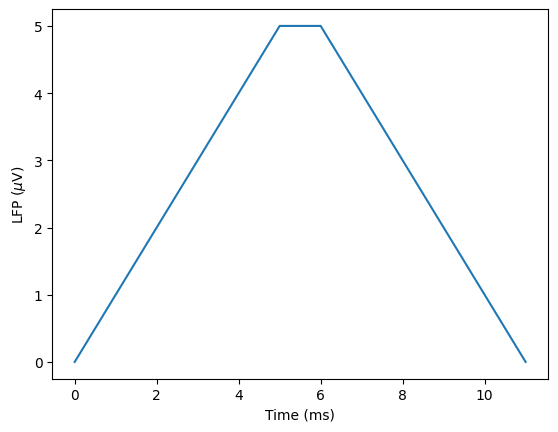

In [23]:
plt.plot(lfp_trace)
plt.xlabel('Time (ms)');
plt.ylabel(r'LFP ($\mu$V)');

You can also use ``neo`` to store spike train data together with metadata in the same object.

**Example**: Create a SpikeTrain object containing the timestamps (the time points at which the neuron fired) ``[50, 100, 200]`` of neuron. Give it units `ms` and have the period start at 0 and stop 300 ms. Display the spike train.

In [24]:
# solution

timestamps = [50, 100, 200]

spike_train = neo.SpikeTrain(timestamps,
                    units='ms',
                    t_start=0*pq.ms,
                    t_stop=300*pq.ms)

spike_train

SpikeTrain containing 3 spikes; units ms; datatype float64 
time: 0.0 ms to 300.0 ms

You can always show the timestamps by typing `.magnitude` behind the spike train object, like in the cell below (simply run it, you don't need to add to the code).

In [25]:
spike_train.magnitude

array([ 50., 100., 200.])

**Exercise**: Create a SpikeTrain object out of the variable `timestamps` containing the time points at which a neuron fired. Give it units `ms` and have the period start at 100 and stop 300 ms. Display the spike train. How many spikes does it say that there are?

In [26]:
timestamps = [120,140,160,180,200,220,240]

In [63]:
# solution


**Exercise**: Get the magnitude of the neo SpikeTrain object. 

In [64]:
# solution


## Section 3

#### Spike-field coherence between LGN spikes and V1 LFP

Coherence is a measure of the linear association between two signals. The spike-field coherence is the association between the spike train of a single neuron and the LFP trace in a single channel and can be used to quantify the relationship between spikes and LFP.

| Code | Description |
| :-- | :-- |
|  `lfp_neo = utils.create_neo_lfp(lfp_trials[:,itrial], sampling_frequency_lfp)` | Utility function to create an analog signal neo object containing the LFP from a single trial `itrial`.|
|  `spiketrain = neo.core.SpikeTrain(timestamps, t_stop = 1.5*pq.s)` | Make a neo SpikeTrain object containing the timestamps at which a cell spiked. `t_stop` specificies when the end of the time window (the highest possible timestamp value) in units of seconds (``pq.s``).|
| `sf_coherence, freqs = spike_field_coherence(lfp_neo, spiketrain=st)` | Calculate the spike-field coherence (sfc) between a spike train and an LFP trace. |
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` ` defines the colormap and the smoothing applied to the plot, respectively. |
| `plt.plot(x, y)`                 | Plots the data in `y` against the corresponding values in `x`. |
| `plt.xlim([some_lower_xlim, some_upper_xlim])`                 | Limit the x-axis in a plot to be betwen the numbers ``some_lower_xlim`` and ``some_upper_xlim``. |
| `transposed_data = data.T`                 | Transposes the dimensions of the data. An array of dimensions N x M will be transposed to M x N, for example. |
| `np.nanmean(data, axis = (dim_num))` | Calculate the average of the data across the `dim_num` dimension of the array while ignoring all NaN-values. |

In [29]:
import matplotlib.pyplot as plt
import neo
import quantities as pq

from elephant.sta import spike_field_coherence

#### Convert spike counts to timestamps

In [67]:
timestamps_LGN = utils.convert_spikes_to_timestamps(spike_counts_LGN)
timestamps_V1 = utils.convert_spikes_to_timestamps(spike_counts_V1)
timestamps_LM = utils.convert_spikes_to_timestamps(spike_counts_LM)

**Example**: Compute the spike field coherence between the LFP in trial ``0`` and the LGN spike train in trial ``0`` for cell ``0``. Plot the coherence using `plt.pcolormesh`.

In [68]:
# solution 
itrial = 0
lfp_neo = utils.create_neo_lfp(lfp_trials[:,itrial], sampling_frequency_lfp)

# put the timestamps in a neo object
icell = 0
timestamps = timestamps_LGN[icell][itrial]
spiketrain_neo = neo.core.SpikeTrain(timestamps, units=pq.ms, t_stop = 1500*pq.ms)

# calculate spike field coherence
sf_coherence, freqs = spike_field_coherence(lfp_neo, spiketrain_neo)

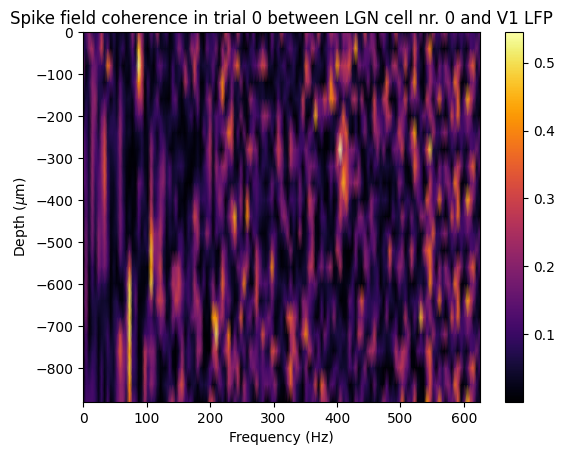

In [69]:
plt.pcolormesh(freqs, channels_depth, sf_coherence.T, cmap = 'inferno', shading = 'gouraud')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Depth ($\mu$m)');
plt.title(f'Spike field coherence in trial {itrial} between LGN cell nr. {icell} and V1 LFP')
plt.colorbar()

**Exercise**: Compute the spike field coherence between the LFP and the LGN spike train in trial at index ``5`` for cell at index ``2``. Plot the coherence using `plt.pcolormesh`. You can use the utility function to create the LFP neo object (found both in the reference table and the example above.)

In [70]:
# solution


**Exercise**: Compute the spike field coherence between the LFP and the **V1** spike train in trial 5 for cell 15. Plot the coherence using `plt.pcolormesh`.

In [71]:
# solution


**DEMO**: Calculate the spike-field coherence between between LGN spike trains and V1 LFP in trial 0 **for all cells**. Loop through all cells, calculate the spike-field coherence, and store the result in a list.

Make a colormap plot of the average spike-field coherence across cells with `pcolormesh`. Are there any frequencies with notably higher coherence?

In [72]:
# solution

itrial = 0
lfp_neo = utils.create_neo_lfp(lfp_trials[:,itrial], sampling_frequency_lfp)

sfc_all_cells_LGN = []
for icell in timestamps_LGN.keys():
    spiketrain_neo = neo.core.SpikeTrain(timestamps_LGN[icell][itrial], units=pq.ms, t_stop = 1500*pq.ms)
    # calculate spike field coherence
    sfc, freqs = spike_field_coherence(lfp_neo, spiketrain_neo)

    sfc_all_cells_LGN.append(sfc.T)

sfc_cell_avg = np.nanmean(sfc_all_cells_LGN, axis = 0)

c:\Users\atle_\anaconda3\envs\lfp_analysis\Lib\site-packages\scipy\signal\_spectral_py.py:1858: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


(0.0, 200.0)

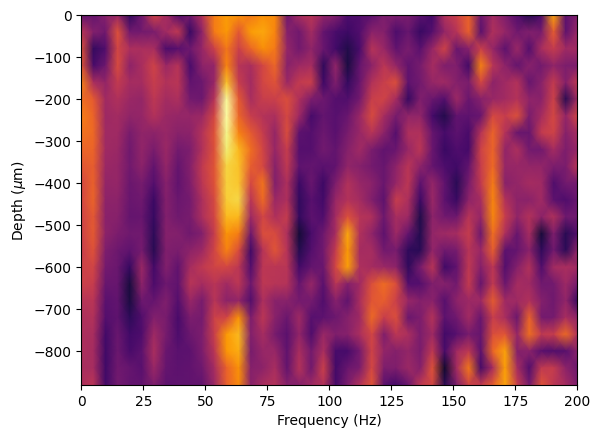

In [73]:
# solution
plt.pcolormesh(freqs, channels_depth, sfc_cell_avg, cmap = 'inferno', shading = 'gouraud')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Depth ($\mu$m)');
plt.xlim([0, 200])

**Exercise**: Compute the average spike field coherence between LGN spikes and V1 LFP (the variable named `sfc_all_cells_LGN` that's calculated in the DEMO above) across **both** cells AND channels (``axis = (0,1)``) and plot the result in a 1D against the frequencies. Are the major peak(s) where you would expect if you compare to the 2D colormap plot of coherence across channels in the demo above?

*Hint*: You may have to use `np.nanmean` to calculate the average, in case there are NaNs in the calculated coherence for some cells.

In [1]:
# solution

**Example**: Calculate the spike-field coherence between between LGN spike trains and V1 LFP. Compute the average across cells, channels, trials (*hint*: `axis = (0,1,2)`) and plot the result against the frequencies.

At which frequencies are the two main peaks in the spike-field coherence between LGN spikes and V1 LFP?

100%|██████████| 27/27 [00:19<00:00,  1.37it/s]


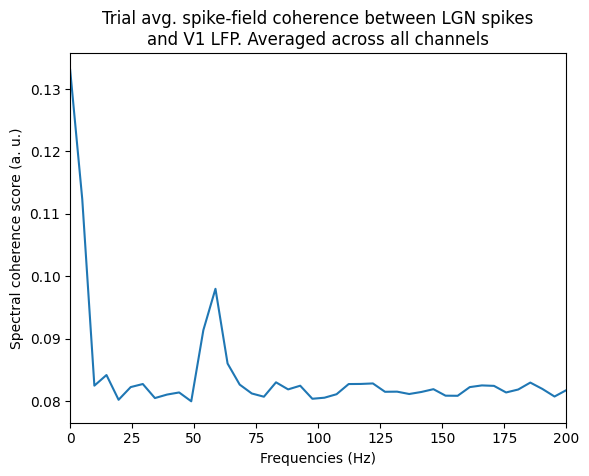

In [ ]:
sfc_all_trials_LGN = utils.get_coherence_all_trials(lfp_trials, timestamps_LGN, sampling_frequency_lfp)

sfc_trial_avg_chan_avg_LGN = np.nanmean(sfc_all_trials_LGN, axis = (0, 1, 2))

plt.plot(freqs, sfc_trial_avg_chan_avg_LGN)
plt.xlim([0,200])

plt.xlabel('Frequencies (Hz)')
plt.ylabel('Spectral coherence score (a. u.)')
plt.title('Trial avg. spike-field coherence between LGN spikes\nand V1 LFP. Averaged across all channels');

Let's check which peaks in the spike-field coherence between LGN spikes and V1 LFP can also be found in the spike-field coherence between spikes in LM or V1 and V1 LFP. If a peak in the spike-field coherence can be observed for all three areas - LGN, V1, and LM - then that's an indication that it's an oscillation that permeates the whole brain region. If a peak can only be observed for one area, that indicates a specific relationship between the spikes in that area (at a certain frequency) and the V1 LFP.

**Exercise**: Calculate the spike-field coherence between between **LM** spike trains and V1 LFP. Compute the average across cells, channels, trials (*hint*: `axis = (0,1,2)`) and plot the result against the frequencies.

Which of the peaks observed in the spike-field coherence between LGN spikes and V1 LFP can also be observed here?

In [76]:
# solution


**Exercise**: Calculate the spike-field coherence between between **V1** spike trains and V1 LFP. Compute the average across cells, channels, trials and plot the result against the frequencies.

Which of the peaks observed in the spike-field coherence between LGN spikes and V1 LFP can also be observed here?

In [77]:
# solution


## Section 4

### Elephant for analyzing spike data

Elephant is a library in Python made specifically for analyzing electrophysiological data. In this section, you'll explore some of its functions to calculate spike statistics.

| Code | Description |
| :-- | :-- |
| `spike_train = homogeneous_poisson_process(rate=some_rate*pq.Hz, t_start=0.*pq.s, t_stop=10.*pq.s)` | Generates a poisson process spiketrain firing at a rate `some_rate` for 10 seconds. |
| `spike_train2 = homogeneous_gamma_process(a=3, b=10*pq.Hz, t_start=0.*pq.s, t_stop=10.*pq.s)` | Generates a gamma process spiketrain firing at a rate `10` Hz for 10 seconds. |
| `stats.mean_firing_rate(spike_train)` | Calculates the average firing rate of the spiketrain. |
| `isi = stats.isi(spike_train)` | Calculates the inter-spike interval (ISI) of the spiketrain.|
| `stats.cv2(isi)` | Calculates the spike interval variability (CV2 score) for a spike train. |
| `plt.eventplot([spike_train1.magnitude, spike_train2.magnitude])` | Creates a raster plot for two spike trains. |
| `stats.time_histogram(spike_trains=spike_train1, bin_size=1*pq.ms)` | Computes the spike counts per unit time (for example per millisecond) from timestamps. |

In [78]:
from elephant.spike_train_generation import homogeneous_poisson_process, homogeneous_gamma_process
from elephant import statistics as stats

#### Generate spike data

Run the cell below to generate three spike trains using Elephant. Two spike trains are generated by a poisson process and the last one is generated by a gamma process.

In [79]:
np.random.seed(2)  
spike_trainA = homogeneous_poisson_process(rate=3*pq.Hz, t_start=0.*pq.s, t_stop=20.*pq.s)
spike_trainB = homogeneous_poisson_process(rate=6*pq.Hz, t_start=0.*pq.s, t_stop=20.*pq.s)
spike_trainC = homogeneous_gamma_process(a=3, b=6*pq.Hz, t_start=0.*pq.s, t_stop=20.*pq.s)

spike_trainA

SpikeTrain containing 68 spikes; units s; datatype float64 
time: 0.0 s to 20.0 s

Run the cell below to create a raster plot of the three spike trains.

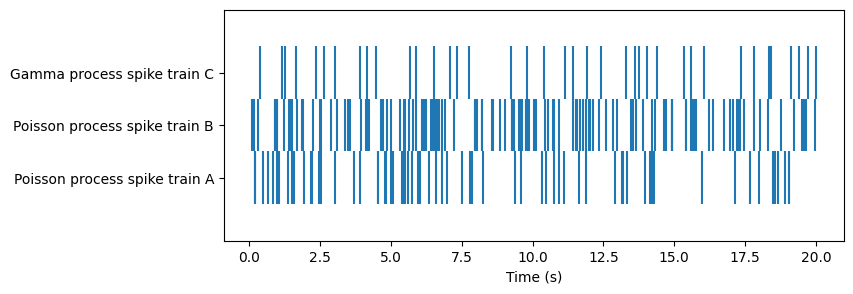

In [80]:
plt.figure(figsize=(8, 3))
plt.eventplot([spike_trainA.magnitude, spike_trainB.magnitude, spike_trainC.magnitude])
plt.xlabel('Time (s)')
plt.yticks([0, 1, 2], labels=["Poisson process spike train A", "Poisson process spike train B", "Gamma process spike train C"]);

**Example**: Calculate average firing rate of spike train A.

In [81]:
firing_rate = stats.mean_firing_rate(spike_trainA)
firing_rate

array(3.4) * 1/s

**Exercise**: Calculate the average firing rate of spike train B.

In [102]:
# solution


**Exercise**: Calculate the average firing rate of the third spike train

In [101]:
# solution


You can calculate the inter-spike intervals (ISI) for a spike train where you get the unit included (it should say `* s` at the end of the array containing the ISIs when you display it).

**Example**: Calculate the ISI for spike train A using ``elephant``'s function ``stats.isi``.

In [84]:
isi_spike_trainA = stats.isi(spike_trainA)

isi_spike_trainA

array([0.00875608, 0.26591931, 0.19050011, 0.18178717, 0.13365914,
       0.07632376, 0.32188912, 0.11872725, 0.10345799, 0.32352409,
       0.25106631, 0.04818009, 0.24022632, 0.06796004, 0.51289243,
       0.64132648, 0.22722893, 0.62481845, 0.02766544, 0.23456493,
       0.02250507, 0.18627672, 0.0338378 , 0.04533433, 0.30272898,
       0.08539964, 0.03770263, 0.08295134, 0.14350523, 0.21023747,
       0.07510832, 0.34092723, 0.21994916, 0.23455862, 0.16307175,
       0.52604024, 0.28917017, 0.05903119, 0.40216126, 1.11322083,
       0.23105463, 0.73430712, 0.13932112, 0.27911682, 0.18594094,
       0.19134228, 0.49953624, 0.25567267, 1.02450859, 0.26190636,
       0.02855376, 0.15208218, 0.63426872, 0.1737797 , 0.00919307,
       0.09464182, 0.02316828, 1.6972101 , 1.17536374, 0.53691017,
       0.30694796, 0.48266632, 0.06179894, 0.11558582, 0.24749264,
       0.1470088 , 0.01558505]) * s

**Exercise**: Calculate the ISI for spike train B.

In [100]:
# solution


**Exercise**: Calculate the ISI for spike train C.

In [99]:
# solution


The interspike intervals can be used to determine whether a spiking neuron is in a bursting, tonic, or poisson firing mode. A bursting neuron fires very often in a short time window but is otherwise mostly silent. A tonic firing mode means that the neuron is firing at highly regular intervals. A poisson firing mode means that the neuron is firing at random and is neither bursting nor in tonic firing mode.

A metric to calculate the the spike interval variability called the CV2 score (``stats.CV2``) is computed from the interspike interval of a neuron. If the CV2 score is 1 (or close to 1), the neuron is firing in a poisson firing mode. If it's > 1, then the neuron is bursting. If it's 0 (or close to 0), then the neuron is in tonic firing mode.

**Example**: Calculate the CV2 of the inter-spike interval (ISI) spike train A.

In [87]:
# solution

cv2_spike_trainA = stats.cv2(isi_spike_trainA)

cv2_spike_trainA

0.9653690108731857

**Exercise**: Calculate the CV2 of the inter-spike interval (ISI) spike train B.

In [98]:
# solution


**Exercise**: Calculate the CV2 of the inter-spike interval (ISI) spike train B.

Which spike trains have a CV2 score closest to 1? Is it the ones you would have expected considering which spike trains were generated with a poisson process?

In [97]:
# solution


The spike trains are stored as timestamps - that is, the time points at which the neuron fired. You can get the spike count within a given time bin (for example, 1 millisecond) with the `stats.time_histogram` function.

**Example**: Get and plot the spike count per milisecond of spike train A.

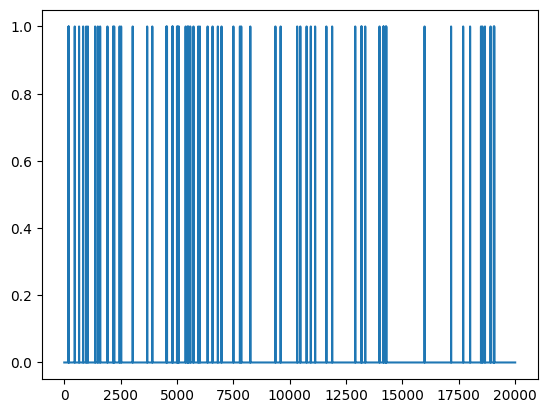

In [ ]:
# solution

spike_countA = stats.time_histogram(spiketrains=spike_trainA, bin_size=1*pq.ms)
plt.plot(spike_countA.magnitude)

**Exercise**: Change the `bin_size` parameter inside the `time_histogram` function to 100 ms (tip: ``bin_size = 100*pq.ms``). Get and plot the spike count per 100 milisecond of spike train A.

In [96]:
# solution


**Exercise**: Get and plot the spike count per 100 milisecond of spike train C.

In [95]:
# solution


**Exercise**: Get and plot the spike count per 1000 milisecond of spike train B.

In [94]:
# solution

